# Recorte de Sahpefiles

In [1]:
import os
from osgeo import ogr
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Primero se hace el clip y la eliminacion de estructuras adicionales a la linea de costa

In [ ]:
import os
import geopandas as gpd
import pandas as pd
from shapely.ops import linemerge, unary_union
from shapely.geometry import LineString, Point
import numpy as np

# ────────────────────────────────────────────────────────
# NUEVA FUNCIÓN DE CONEXIÓN DE LÍNEAS

def conectar_lineas(exploded, tolerance=500):  # tolerance en metros
    lines = list(exploded.geometry)
    
    if len(lines) == 1:
        return lines[0]

    # Obtener los extremos de todas las líneas
    endpoints = []
    for line in lines:
        endpoints.append(Point(line.coords[0]))
        endpoints.append(Point(line.coords[-1]))

    # Calcular distancias entre extremos
    dist_matrix = np.zeros((len(endpoints), len(endpoints)))
    for i, p1 in enumerate(endpoints):
        for j, p2 in enumerate(endpoints):
            dist_matrix[i][j] = p1.distance(p2)

    # Conectar extremos cercanos
    connected_segments = lines.copy()
    for i in range(len(endpoints)):
        for j in range(i+1, len(endpoints)):
            if 0 < dist_matrix[i][j] < tolerance:
                seg = LineString([endpoints[i], endpoints[j]])
                connected_segments.append(seg)

    # Hacer linemerge sobre todo
    merged = linemerge(connected_segments)

    if merged.geom_type == 'MultiLineString':
        merged = max(merged.geoms, key=lambda x: x.length)
    
    return merged

# ────────────────────────────────────────────────────────
# PROCESAMIENTO

# Directorios base
base_dir = r'C:\1_ENSOCE\C3_Output\shapes'
clip_shapefile = os.path.join(base_dir, 'coastlinesh4326.shp')

clip_gdf = gpd.read_file(clip_shapefile).to_crs(epsg=32613)
years = ["2022", "2023", "2024"]

meses_dict = {
    "1_enero": "a_enero", "2_febrero": "b_febrero", "3_marzo": "c_marzo",
    "4_abril": "d_abril", "5_mayo": "e_mayo", "6_junio": "f_junio",
    "7_julio": "g_julio", "8_agosto": "h_agosto", "9_septiembre": "i_septiembre",
    "10_octubre": "j_octubre", "11_noviembre": "k_noviembre", "12_diciembre": "l_diciembre"
}

gdfs_clipped_total = []

for year in years:
    print(f"\nProcesando año {year}...")# ───────────────────────────────────────────────────────────────
# IMPORTACIONES
# ───────────────────────────────────────────────────────────────
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import linemerge

# ───────────────────────────────────────────────────────────────
# FUNCIONES
# ───────────────────────────────────────────────────────────────

def conectar_lineas(exploded, tolerance=500):
    """
    Conecta extremos de múltiples líneas si están a una distancia menor a la tolerancia.
    """
    lines = list(exploded.geometry)
    if len(lines) == 1:
        return lines[0]

    endpoints = []
    for line in lines:
        endpoints.append(Point(line.coords[0]))
        endpoints.append(Point(line.coords[-1]))

    dist_matrix = np.zeros((len(endpoints), len(endpoints)))
    for i, p1 in enumerate(endpoints):
        for j, p2 in enumerate(endpoints):
            dist_matrix[i][j] = p1.distance(p2)

    connected_segments = lines.copy()
    for i in range(len(endpoints)):
        for j in range(i + 1, len(endpoints)):
            if 0 < dist_matrix[i][j] < tolerance:
                seg = LineString([endpoints[i], endpoints[j]])
                connected_segments.append(seg)

    merged = linemerge(connected_segments)
    if merged.geom_type == 'MultiLineString':
        merged = max(merged.geoms, key=lambda x: x.length)
    
    return merged


def force_linestring(geom):
    """
    Asegura que una geometría sea LineString (toma la más larga si es MultiLineString).
    """
    if geom.geom_type == 'MultiLineString':
        return max(list(geom.geoms), key=lambda x: x.length)
    elif geom.geom_type == 'LineString':
        return geom
    return None


def strip_z(geom):
    """
    Elimina la dimensión Z (altitud) de una geometría si está presente.
    """
    if hasattr(geom, 'coords'):
        coords_2d = [(x, y) for x, y, *_ in geom.coords]
        return LineString(coords_2d)
    return geom

# ───────────────────────────────────────────────────────────────
# CONFIGURACIÓN DE ENTRADA / SALIDA
# ───────────────────────────────────────────────────────────────

base_dir = r'C:\1_ENSOCE\C3_Output\shapes'
clip_shapefile = os.path.join(base_dir, 'coastlinesh4326.shp')
clip_gdf = gpd.read_file(clip_shapefile).to_crs(epsg=32613)

years = ["2022", "2023", "2024"]
meses_dict = {
    "1_enero": "a_enero", "2_febrero": "b_febrero", "3_marzo": "c_marzo",
    "4_abril": "d_abril", "5_mayo": "e_mayo", "6_junio": "f_junio",
    "7_julio": "g_julio", "8_agosto": "h_agosto", "9_septiembre": "i_septiembre",
    "10_octubre": "j_octubre", "11_noviembre": "k_noviembre", "12_diciembre": "l_diciembre"
}

# ───────────────────────────────────────────────────────────────
# PROCESAMIENTO PRINCIPAL POR AÑO Y MES
# ───────────────────────────────────────────────────────────────

gdfs_clipped_total = []

for year in years:
    print(f"\n🟢 Procesando año {year}...")
    input_base = os.path.join(base_dir, f'{year}shapes', 'input')
    output_base = os.path.join(base_dir, f'{year}shapes', 'output')
    os.makedirs(output_base, exist_ok=True)

    meses_id = {mes: f"{label}_{year}" for mes, label in meses_dict.items()}
    gdfs_clipped = []

    for subfolder in os.listdir(input_base):
        subfolder_path = os.path.join(input_base, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        shp_files = [f for f in os.listdir(subfolder_path) if f.endswith('.shp')]
        if not shp_files:
            print(f"⚠️ No se encontró shapefile en {subfolder_path}")
            continue

        # Leer y recortar con el shapefile de la costa
        shp_path = os.path.join(subfolder_path, shp_files[0])
        gdf = gpd.read_file(shp_path).to_crs(epsg=32613)
        clipped = gpd.overlay(gdf, clip_gdf, how='intersection')

        if clipped.empty:
            print(f"⚠️ Clip vacío en {subfolder}")
            continue

        # Explode y filtro por longitud mínima
        exploded = clipped.explode(index_parts=False)
        exploded = exploded[exploded.length > 80000]

        if exploded.empty:
            print(f"⚠️ Sin líneas suficientemente largas en {subfolder}")
            continue

        try:
            # Conexión de líneas
            if len(exploded) > 1:
                merged_line = conectar_lineas(exploded, tolerance=500)
            else:
                merged_line = exploded.geometry.values[0]

            if merged_line.geom_type == 'MultiLineString':
                merged_line = max(merged_line.geoms, key=lambda x: x.length)

            id_label = meses_id.get(subfolder, f"{subfolder}_{year}")
            longest_line = gpd.GeoDataFrame({'id': [id_label]}, geometry=[merged_line], crs="EPSG:32613")

            output_name = f"{subfolder}_{year}_mz.shp"
            output_path = os.path.join(output_base, output_name)
            longest_line.to_file(output_path)

            print(f"✅ Guardado: {output_path}")
            gdfs_clipped.append(longest_line)

        except Exception as e:
            print(f"❌ Error al unir líneas en {subfolder}: {e}")

    if gdfs_clipped:
        gdfs_clipped_total.extend(gdfs_clipped)

# ───────────────────────────────────────────────────────────────
# UNIÓN FINAL Y EXPORTACIÓN PARA DSAS
# ───────────────────────────────────────────────────────────────

if gdfs_clipped_total:
    print("\n🧩 Uniendo líneas de todos los años...")
    merged = gpd.GeoDataFrame(pd.concat(gdfs_clipped_total, ignore_index=True), crs="EPSG:32613")
    merged['geometry'] = merged['geometry'].apply(force_linestring).apply(strip_z)
    merged = merged[merged.is_valid]
    merged_wgs84 = merged.to_crs(epsg=4326)

    output_dsas_geojson = os.path.join(base_dir, 'shapes_total_dsas.geojson')
    merged_wgs84.to_file(output_dsas_geojson, driver="GeoJSON")
    print(f"\n🎉 Archivo DSAS final exportado en:\n{output_dsas_geojson}")
else:
    print("⚠️ No se generaron recortes.")

    
    input_base = os.path.join(base_dir, f'{year}shapes', 'input')
    output_base = os.path.join(base_dir, f'{year}shapes', 'output')
    os.makedirs(output_base, exist_ok=True)
    
    meses_id = {mes: f"{label}_{year}" for mes, label in meses_dict.items()}
    gdfs_clipped = []

    for subfolder in os.listdir(input_base):
        subfolder_path = os.path.join(input_base, subfolder)
        if os.path.isdir(subfolder_path):
            shp_files = [f for f in os.listdir(subfolder_path) if f.endswith('.shp')]
            if not shp_files:
                print(f"No se encontró shapefile en {subfolder_path}")
                continue

            shp_path = os.path.join(subfolder_path, shp_files[0])
            gdf = gpd.read_file(shp_path).to_crs(epsg=32613)

            clipped = gpd.overlay(gdf, clip_gdf, how='intersection')

            if not clipped.empty:
                exploded = clipped.explode(index_parts=False)
                exploded = exploded[exploded.length > 80000]

                if not exploded.empty:
                    try:
                        if len(exploded) > 1:
                            # Aquí aplicamos la nueva función:
                            merged_line = conectar_lineas(exploded, tolerance=500)
                        else:
                            merged_line = exploded.geometry.values[0]

                        # Aseguramos que sea LineString
                        if merged_line.geom_type == 'MultiLineString':
                            merged_line = max(merged_line.geoms, key=lambda x: x.length)

                        id_label = meses_id.get(subfolder, f"{subfolder}_{year}")

                        longest_line = gpd.GeoDataFrame({'id': [id_label]}, geometry=[merged_line], crs="EPSG:32613")

                        output_name = f"{subfolder}_{year}_mz.shp"
                        output_path = os.path.join(output_base, output_name)
                        longest_line.to_file(output_path)
                        print(f"Guardado: {output_path}")

                        gdfs_clipped.append(longest_line)

                    except Exception as e:
                        print(f"Error al unir líneas en {subfolder}: {e}")
                else:
                    print(f"Sin líneas suficientemente largas en {subfolder}")
            else:
                print(f"Clip vacío en {subfolder}")

    if gdfs_clipped:
        gdfs_clipped_total.extend(gdfs_clipped)

# Unimos y exportamos
if gdfs_clipped_total:
    merged = gpd.GeoDataFrame(pd.concat(gdfs_clipped_total, ignore_index=True), crs="EPSG:32613")

    def force_linestring(geom):
        if geom.geom_type == 'MultiLineString':
            return max(list(geom.geoms), key=lambda x: x.length)
        elif geom.geom_type == 'LineString':
            return geom
        return None

    def strip_z(geom):
        if hasattr(geom, 'coords'):
            coords_2d = [(x, y) for x, y, *_ in geom.coords]
            return LineString(coords_2d)
        return geom

    merged['geometry'] = merged['geometry'].apply(force_linestring).apply(strip_z)
    merged = merged[merged.is_valid]
    merged_wgs84 = merged.to_crs(epsg=4326)

    output_dsas_geojson = os.path.join(base_dir, 'shapes_total_dsas.geojson')
    merged_wgs84.to_file(output_dsas_geojson, driver="GeoJSON")
    print(f"\n✅ Archivo DSAS final exportado en: {output_dsas_geojson}")
else:
    print("No se generaron recortes.")



Procesando año 2022...
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\10_octubre_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\11_noviembre_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\12_diciembre_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\1_enero_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\2_febrero_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\3_marzo_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\4_abril_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes\2022shapes\output\5_mayo_2022_mz.shp
Guardado: C:\Users\c4cfo\OneDrive\

       length_m
0  74417.204924


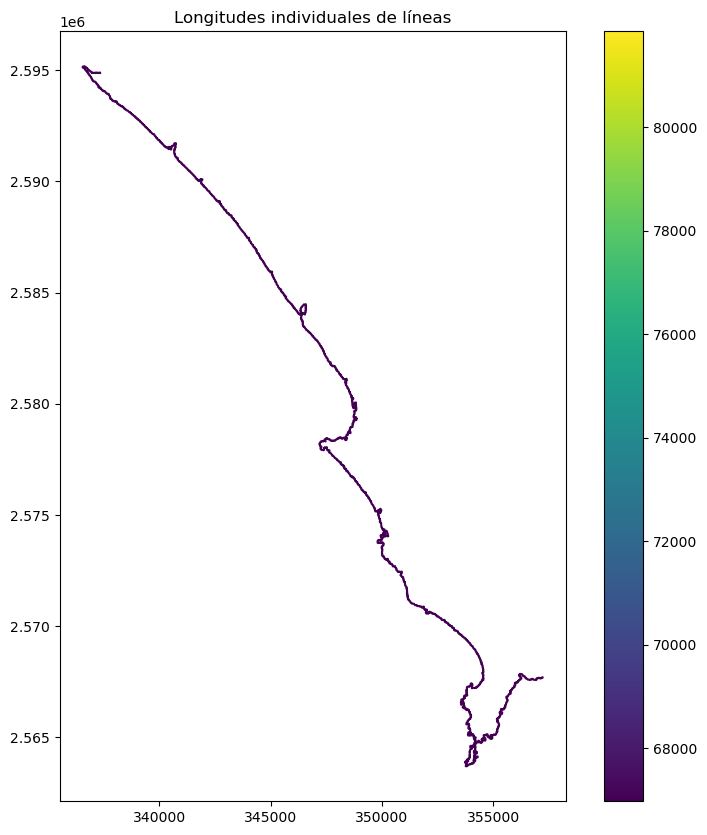

In [ ]:
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# Solo haremos la prueba para un archivo
# Selecciona el path de alguno de tus archivos recortados
test_shp_path = r"C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\3_marzo_2022_mz.shp"

# Leer archivo
gdf = gpd.read_file(test_shp_path)

# Explode
exploded = gdf.explode(index_parts=False)

# Agregar columna de longitud
exploded["length_m"] = exploded.length

# Imprimir resumen
print(exploded[["length_m"]].sort_values("length_m", ascending=False))

# Graficar con colores según longitud
exploded.plot(column="length_m", cmap="viridis", legend=True, figsize=(10, 10))
plt.title("Longitudes individuales de líneas")
plt.show()


In [ ]:
# FUNCIÓN PARA RESAMPLEAR LAS LÍNEAS

def resample_line(line, num_points):
    distances = np.linspace(0, line.length, num_points)
    points = [line.interpolate(d) for d in distances]
    return LineString(points)

# ─────────────────────────────────────────────────────
# PARÁMETROS
num_points = 1000000  # número de puntos normalizados por línea

# ─────────────────────────────────────────────────────
# NORMALIZACIÓN DE TODAS LAS LÍNEAS

resampled_lines = []
for geom in merged_wgs84.geometry:
    if geom.length == 0:
        continue  # Evitar geometrías vacías
    resampled = resample_line(geom, num_points)
    resampled_lines.append(resampled)

# ─────────────────────────────────────────────────────
# PROMEDIO DE COORDENADAS

# Convertimos a arrays de coordenadas
coords_array = np.array([np.array(line.coords) for line in resampled_lines])

# Calculamos el promedio coordenada a coordenada
mean_x = np.mean(coords_array[:, :, 0], axis=0)
mean_y = np.mean(coords_array[:, :, 1], axis=0)

# Reconstruimos la línea promedio
mean_coords = list(zip(mean_x, mean_y))
mean_line = LineString(mean_coords)

# ─────────────────────────────────────────────────────
# EXPORTACIÓN DE LA LÍNEA BASE PROMEDIO

baseline_gdf = gpd.GeoDataFrame({'id': ['baseline_mean']}, geometry=[mean_line], crs=merged_wgs84.crs)
baseline_path = os.path.join(base_dir, 'baseline_dsas.geojson')
baseline_gdf.to_file(baseline_path, driver='GeoJSON')

print(f"✅ Línea base promedio DSAS generada en: {baseline_path}")

C:\Users\c4cfo\AppData\Local\Temp\ipykernel_17388\2174559628.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(ids))


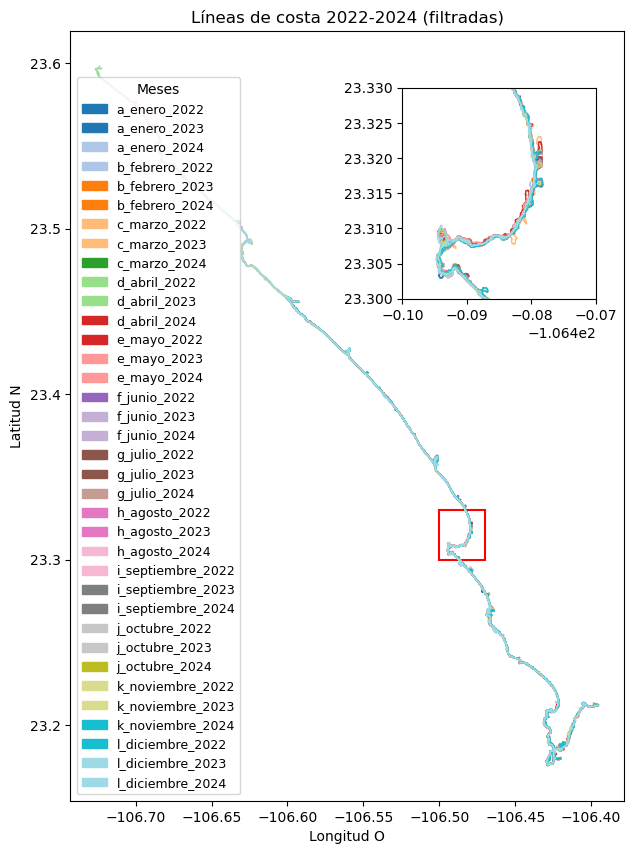

In [12]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

# Cargar el GeoJSON final
geojson_path = output_dsas_geojson
gdf = gpd.read_file(geojson_path)
gdf_lines = gdf[gdf.geometry.type.isin(['LineString', 'MultiLineString'])]

fig, ax = plt.subplots(figsize=(12, 10))

# Ordenamos alfabéticamente los IDs
ids = sorted(gdf_lines['id'].tolist())

# Creamos un nuevo GeoDataFrame ordenado alfabéticamente
gdf_lines_sorted = gdf_lines.set_index('id').loc[ids].reset_index()

# Colormap de colores únicos por id
colors = plt.cm.get_cmap('tab20', len(ids))

# Dibujar cada línea con su color asignado
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=ax, color=colors(idx), linewidth=1, label=row['id'])

# Generar patches para la leyenda en orden alfabético
handles = [mpatches.Patch(color=colors(i), label=ids[i]) for i in range(len(ids))]

# Agregar la leyenda abajo a la izquierda
ax.legend(handles=handles, loc='lower left', fontsize=9, frameon=True, title="Meses")

# Título y ejes
ax.set_title("Líneas de costa 2022-2024 (filtradas)")
ax.set_xlabel("Longitud O")
ax.set_ylabel("Latitud N")

# Inset
axins = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=2)
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=axins, color=colors(idx), linewidth=1)

# Ajuste del zoom del inset
axins.set_xlim(-106.50, -106.47)
axins.set_ylim(23.3, 23.33)

# Rectángulo del área de zoom
rect = plt.Rectangle((-106.5, 23.3), 0.03, 0.03, linewidth=1.5, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()


In [ ]:
import os
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union, snap
from shapely.affinity import translate


# ========= CONFIGURACIÓN =========
input_shapefile = r"C:\1_ENSOCE\C3_Output\202308mazatlanv2.shp"
output_folder = r"C:\1_ENSOCE\C3_Output"
output_filename = "baseline_dsas.geojson"
output_path = os.path.join(output_folder, output_filename)

# ========= 1. Cargar y reproyectar a metros (EPSG:32613) =========
gdf = gpd.read_file(input_shapefile)
gdf = gdf.to_crs("EPSG:32613")

# ========= 2. Unir todas las líneas en una sola (snapping y linemerge) =========
# Aplicamos snapping para unir nodos cercanos dentro de una tolerancia
tolerance = 5  # metros; ajusta según tus datos
snapped_geoms = [snap(geom, unary_union(gdf.geometry), tolerance) for geom in gdf.geometry]

# Aplicamos unary_union + linemerge para unir correctamente
union = linemerge(unary_union(snapped_geoms))

# Si aún es MultiLineString, concatenamos coordenadas (último recurso)
if union.geom_type == "MultiLineString":
    coords = []
    for line in union.geoms:
        coords.extend(line.coords)
    union = LineString(coords)


# ========= 3. Desplazar hacia el noreste (ej. 200 m) =========
desplazada = translate(union, xoff=200, yoff=200)

# ========= 4. Crear GeoDataFrame con CRS correcto =========
gdf_out = gpd.GeoDataFrame({
        'Id': [1],
        'Attribute': ['baseline_1']
    }, geometry=[baseline], crs="EPSG:32613")

# ========= 5. Convertir a EPSG:4326 y guardar como GeoJSON =========
#gdf_out = gdf_out.to_crs("EPSG:4326")
gdf_out.to_file(output_path, driver="GeoJSON")

print(f"✅ Línea base desplazada al noreste guardada en:\n{output_path}")


✅ Línea base desplazada al noreste guardada en:
C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\baseline_dsas.geojson


In [6]:
import os
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString
from shapely.ops import linemerge, unary_union, snap

# ========= CONFIGURACIÓN =========
input_shapefile = r"C:\1_ENSOCE\C3_Output\202308mazatlanv2.shp"
output_folder = r"C:\1_ENSOCE\C3_Output"
output_filename = "baseline_dsas.geojson"
output_path = os.path.join(output_folder, output_filename)

# Distancia del offset en metros
distancia = 200

# ========= 1. Cargar y reproyectar a metros (EPSG:32613) =========
gdf = gpd.read_file(input_shapefile)
gdf = gdf.to_crs("EPSG:32613")

# ========= 2. Snap para unir nodos cercanos y unir geometrías =========
tolerance = 5  # metros
snapped_geoms = [snap(geom, unary_union(gdf.geometry), tolerance) for geom in gdf.geometry]
union = linemerge(unary_union(snapped_geoms))

# Si aún es MultiLineString, concatenar coordenadas como último recurso
if union.geom_type == "MultiLineString":
    coords = []
    for line in union.geoms:
        coords.extend(line.coords)
    union = LineString(coords)

# ========= 3. Generar baseline usando offset paralelo =========
try:
    # Offset hacia tierra (lado 'left' si la línea tiene orientación mar-tierra)
    baseline = union.parallel_offset(distancia, side='right', resolution=256, join_style=2)
    if baseline.geom_type == "MultiLineString":
        baseline = linemerge(baseline)
except Exception as e:
    raise ValueError(f"❌ No se pudo generar la línea offset: {e}")

# ========= 4. Crear GeoDataFrame y exportar =========
gdf_out = gpd.GeoDataFrame({
        'id': [1],
        'Attribute': ['baseline_1']
    }, geometry=[baseline], crs="EPSG:32613")
#gdf_out = gdf_out.to_crs("EPSG:4326")
gdf_out.to_file(output_path, driver="GeoJSON")

print(f"✅ Línea base (parallel offset) guardada en:\n{output_path}")
total_perimetro = gdf_out.length.sum()
print(f"🔹 Perímetro total del buffer: {total_perimetro:.2f} metros")


✅ Línea base (parallel offset) guardada en:
C:\1_ENSOCE\C3_Output\baseline_dsas.geojson
🔹 Perímetro total del buffer: 47087.19 metros


47087


🟢 Procesando año 2022...
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\10_octubre_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\11_noviembre_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\12_diciembre_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\1_enero_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\2_febrero_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\3_marzo_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\4_abril_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\5_mayo_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\6_junio_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\7_julio_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\8_agosto_2022_mz.shp
✅ Guardado: C:\1_ENSOCE\C3_Output\shapes\2022shapes\output\9_septiembre_2022_mz.shp

🟢 Pro

AttributeError: 'numpy.ndarray' object has no attribute 'coords'

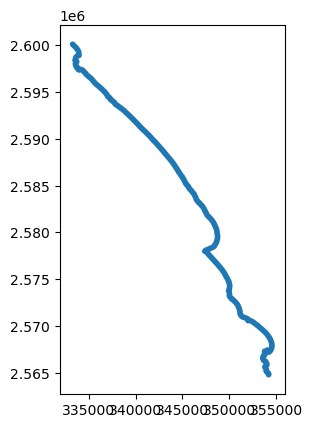

In [7]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString, MultiLineString, Point
from shapely.ops import linemerge

# ───────────────────────────────────────────────────────────────
# FUNCIONES AUXILIARES
# ───────────────────────────────────────────────────────────────

def conectar_lineas(exploded, tolerance=500):
    """
    Conecta extremos de múltiples líneas si están a una distancia menor a la tolerancia.
    """
    lines = list(exploded.geometry)
    if len(lines) == 1:
        return lines[0]

    endpoints = []
    for line in lines:
        endpoints.append(Point(line.coords[0]))
        endpoints.append(Point(line.coords[-1]))

    dist_matrix = np.zeros((len(endpoints), len(endpoints)))
    for i, p1 in enumerate(endpoints):
        for j, p2 in enumerate(endpoints):
            dist_matrix[i][j] = p1.distance(p2)

    connected_segments = lines.copy()
    for i in range(len(endpoints)):
        for j in range(i + 1, len(endpoints)):
            if 0 < dist_matrix[i][j] < tolerance:
                seg = LineString([endpoints[i], endpoints[j]])
                connected_segments.append(seg)

    merged = linemerge(connected_segments)
    if merged.geom_type == 'MultiLineString':
        merged = max(merged.geoms, key=lambda x: x.length)
    
    return merged

def force_linestring(geom):
    if geom.geom_type == 'MultiLineString':
        return max(list(geom.geoms), key=lambda x: x.length)
    elif geom.geom_type == 'LineString':
        return geom
    return None

def strip_z(geom):
    if hasattr(geom, 'coords'):
        coords_2d = [(x, y) for x, y, *_ in geom.coords]
        return LineString(coords_2d)
    return geom

# ───────────────────────────────────────────────────────────────
# CONFIGURACIÓN GENERAL
# ───────────────────────────────────────────────────────────────

base_dir = r'C:\1_ENSOCE\C3_Output\shapes'
bl_output_filename = "202308mazatlanv2.shp"
# ========= CREAR BUFFER DE 100m DESDE LA LÍNEA BASE =========
baseline_path = os.path.join(output_folder, bl_output_filename)
baseline_gdf = gpd.read_file(baseline_path).to_crs(epsg=32613)

# Generar buffer de 300 metros
clip_gdf = baseline_gdf.copy()
clip_gdf['geometry'] = clip_gdf.buffer(300)

# Verificación opcional:
clip_gdf.plot()


years = ["2022", "2023", "2024"]
meses_dict = {
    "1_enero": "a_enero", "2_febrero": "b_febrero", "3_marzo": "c_marzo",
    "4_abril": "d_abril", "5_mayo": "e_mayo", "6_junio": "f_junio",
    "7_julio": "g_julio", "8_agosto": "h_agosto", "9_septiembre": "i_septiembre",
    "10_octubre": "j_octubre", "11_noviembre": "k_noviembre", "12_diciembre": "l_diciembre"
}

# ───────────────────────────────────────────────────────────────
# PROCESAMIENTO POR AÑO Y MES
# ───────────────────────────────────────────────────────────────

gdfs_clipped_total = []

for year in years:
    print(f"\n🟢 Procesando año {year}...")
    input_base = os.path.join(base_dir, f'{year}shapes', 'input')
    output_base = os.path.join(base_dir, f'{year}shapes', 'output')
    os.makedirs(output_base, exist_ok=True)

    meses_id = {mes: f"{label}_{year}" for mes, label in meses_dict.items()}
    gdfs_clipped = []

    for subfolder in os.listdir(input_base):
        subfolder_path = os.path.join(input_base, subfolder)
        if not os.path.isdir(subfolder_path):
            continue

        shp_files = [f for f in os.listdir(subfolder_path) if f.endswith('.shp')]
        if not shp_files:
            print(f"⚠️ No se encontró shapefile en {subfolder_path}")
            continue

        shp_path = os.path.join(subfolder_path, shp_files[0])
        gdf = gpd.read_file(shp_path).to_crs(epsg=32613)
        clipped = gpd.overlay(gdf, clip_gdf, how='intersection')

        if clipped.empty:
            print(f"⚠️ Clip vacío en {subfolder}")
            continue

        exploded = clipped.explode(index_parts=False)
        exploded = exploded[exploded.length > 1000]

        if exploded.empty:
            print(f"⚠️ Sin líneas suficientemente largas en {subfolder}")
            continue

        try:
            if len(exploded) > 1:
                merged_line = conectar_lineas(exploded, tolerance=500)
            else:
                merged_line = exploded.geometry.values[0]

            if merged_line.geom_type == 'MultiLineString':
                merged_line = max(merged_line.geoms, key=lambda x: x.length)

            id_label = meses_id.get(subfolder, f"{subfolder}_{year}")
            longest_line = gpd.GeoDataFrame({'id': [id_label]}, geometry=[merged_line], crs="EPSG:32613")

            output_name = f"{subfolder}_{year}_mz.shp"
            output_path = os.path.join(output_base, output_name)
            longest_line.to_file(output_path)

            print(f"✅ Guardado: {output_path}")
            gdfs_clipped.append(longest_line)

        except Exception as e:
            print(f"❌ Error al unir líneas en {subfolder}: {e}")

    if gdfs_clipped:
        gdfs_clipped_total.extend(gdfs_clipped)

# ───────────────────────────────────────────────────────────────
# UNIÓN FINAL Y EXPORTACIÓN PARA DSAS
# ───────────────────────────────────────────────────────────────

if gdfs_clipped_total:
    print("\n🧩 Uniendo líneas de todos los años...")
    merged = gpd.GeoDataFrame(pd.concat(gdfs_clipped_total, ignore_index=True), crs="EPSG:32613")
    merged['geometry'] = merged['geometry'].apply(force_linestring).apply(strip_z)
    merged = merged[merged.is_valid]

    # Construir campo 'date' con MM/DD/YYYY y 'Uncertainty'
    id_to_date = {}
    for mes, letra in meses_dict.items():
        numero_mes = mes.split("_")[0].zfill(2)
        for year in years:
            id_dsas = f"{letra}_{year}"
            fecha = f"{numero_mes}/01/{year}"
            id_to_date[id_dsas] = fecha

    merged['date'] = merged['id'].map(id_to_date)
    merged['Uncertainty'] = 10  # Puedes ajustar según la fuente

    # Exportar en WGS84 como GeoJSON para DSAS
    #merged_wgs84 = merged.to_crs(epsg=4326)
    output_dsas_geojson = os.path.join(base_dir, 'shapes_total_dsas.geojson')
    #merged_wgs84.to_file(output_dsas_geojson, driver="GeoJSON")
    merged.to_file(output_dsas_geojson, driver="GeoJSON")

    print(f"\n🎉 Archivo DSAS final exportado en:\n{output_dsas_geojson}")
else:
    print("⚠️ No se generaron recortes.")
    
    
 #----------------------------------------------------------------------------   

print("\n🍂 Calculando líneas promedio por estación...")
base_dir = r'C:\1_ENSOCE\C3_Output\shapes'

output_season_dir = os.path.join(base_dir, "estaciones")
os.makedirs(output_season_dir, exist_ok=True)
years = ["2022", "2023", "2024"]

estaciones = {
    "primavera": ["c_marzo", "d_abril", "e_mayo"],
    "verano": ["f_junio", "g_julio", "h_agosto"],
    "otoño": ["i_septiembre", "j_octubre", "k_noviembre"]
}

gdfs_estaciones = []  # Para juntar todas las líneas promedio
num_points = int(total_perimetro.round())
# PRIMAVERA, VERANO, OTOÑO
for year in years:
    for estacion, letras in estaciones.items():
        ids_estacion = [f"{letra}_{year}" for letra in letras]
        subset = merged[merged["id"].isin(ids_estacion)]

        if subset.empty:
            print(f"⚠️ No hay datos para {estacion} {year}")
            continue

        interpolated_lines = []
        
        for geom in subset.geometry:
            coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
            interpolated_lines.append(coords)

        avg_coords = np.mean(np.array(interpolated_lines), axis=0)
        linea_promedio = LineString(avg_coords)

        gdf_prom = gpd.GeoDataFrame({
            "id": [f"{estacion}_{year}"],
            "date": [f"01/01/{year}"],
            "Uncertainty": [20]
        }, geometry=[linea_promedio], crs="EPSG:32613")

        gdfs_estaciones.append(gdf_prom)
        print(f"✅ Línea promedio generada: {estacion}_{year}")

# INVIERNO 2022: enero + febrero
ids_inv_2022 = ["a_enero_2022", "b_febrero_2022"]
subset_2022 = merged[merged["id"].isin(ids_inv_2022)]

if not subset_2022.empty:
    interpolated = []
    for geom in subset_2022.geometry:
        coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
        interpolated.append(coords)
    avg = np.mean(np.array(interpolated), axis=0)
    linea = LineString(avg)
    gdf_2022 = gpd.GeoDataFrame({
        "id": ["invierno_2022"],
        "date": ["01/01/2022"],
        "Uncertainty": [20]
    }, geometry=[linea], crs="EPSG:32613")
    gdfs_estaciones.append(gdf_2022)
    print("✅ Línea promedio generada: invierno_2022")

# INVIERNO 2023: diciembre_2022 + enero_2023 + febrero_2023
ids_inv_2023 = ["l_diciembre_2022", "a_enero_2023", "b_febrero_2023"]
subset_2023 = merged[merged["id"].isin(ids_inv_2023)]

if not subset_2023.empty:
    interpolated = []
    for geom in subset_2023.geometry:
        coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
        interpolated.append(coords)
    avg = np.mean(np.array(interpolated), axis=0)
    linea = LineString(avg)
    gdf_2023 = gpd.GeoDataFrame({
        "id": ["invierno_2023"],
        "date": ["01/01/2023"],
        "Uncertainty": [20]
    }, geometry=[linea], crs="EPSG:32613")
    gdfs_estaciones.append(gdf_2023)
    print("✅ Línea promedio generada: invierno_2023")

# Concatenar y exportar como GeoJSON en EPSG:4326
if gdfs_estaciones:
    merged_seasonal = gpd.GeoDataFrame(pd.concat(gdfs_estaciones, ignore_index=True), crs="EPSG:32613")
    #merged_seasonal = merged_seasonal.to_crs(epsg=4326)
    output_geojson = os.path.join(output_season_dir, "estacionesenso.geojson")
    merged_seasonal.to_file(output_geojson, driver="GeoJSON")
    print(f"\n🎉 Archivo final exportado: {output_geojson}")
else:
    print("⚠️ No se generaron líneas promedio por estación.")


C:\Users\c4cfo\AppData\Local\Temp\ipykernel_9432\2174559628.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(ids))


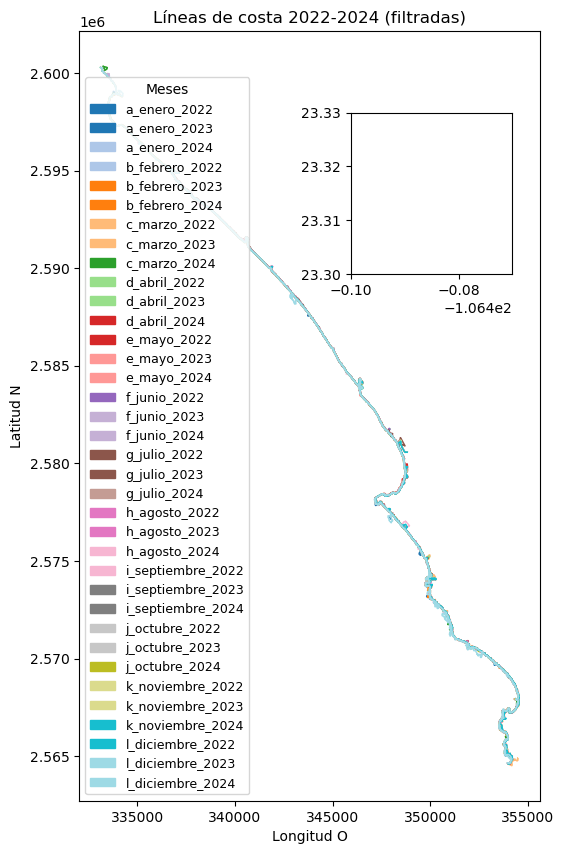

In [26]:
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os

# Cargar el GeoJSON final
geojson_path = output_dsas_geojson
gdf = gpd.read_file(geojson_path)
gdf_lines = gdf[gdf.geometry.type.isin(['LineString', 'MultiLineString'])]

fig, ax = plt.subplots(figsize=(12, 10))

# Ordenamos alfabéticamente los IDs
ids = sorted(gdf_lines['id'].tolist())

# Creamos un nuevo GeoDataFrame ordenado alfabéticamente
gdf_lines_sorted = gdf_lines.set_index('id').loc[ids].reset_index()

# Colormap de colores únicos por id
colors = plt.cm.get_cmap('tab20', len(ids))

# Dibujar cada línea con su color asignado
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=ax, color=colors(idx), linewidth=1, label=row['id'])

# Generar patches para la leyenda en orden alfabético
handles = [mpatches.Patch(color=colors(i), label=ids[i]) for i in range(len(ids))]

# Agregar la leyenda abajo a la izquierda
ax.legend(handles=handles, loc='lower left', fontsize=9, frameon=True, title="Meses")

# Título y ejes
ax.set_title("Líneas de costa 2022-2024 (filtradas)")
ax.set_xlabel("Longitud O")
ax.set_ylabel("Latitud N")

# Inset
axins = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=2)
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=axins, color=colors(idx), linewidth=1)

# Ajuste del zoom del inset
axins.set_xlim(-106.50, -106.47)
axins.set_ylim(23.3, 23.33)

# Rectángulo del área de zoom
rect = plt.Rectangle((-106.5, 23.3), 0.03, 0.03, linewidth=1.5, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()


In [ ]:
# ───────────────────────────────────────────────────────────────
# PROMEDIO POR ESTACIONES DEL AÑO
# ───────────────────────────────────────────────────────────────

print("\n🍂 Calculando líneas promedio por estación...")

# Crear carpeta de salida
output_season_dir = os.path.join(base_dir, "estaciones")
os.makedirs(output_season_dir, exist_ok=True)

# Definir estaciones y meses asociados
estaciones = {
    "invierno": ["a_enero", "b_febrero"],
    "primavera": ["c_marzo", "d_abril", "e_mayo"],
    "verano": ["f_junio", "g_julio", "h_agosto"],
    "otoño": ["i_septiembre", "j_octubre", "k_noviembre"]
}

# Para cada año y estación
for year in years:
    for estacion, letras in estaciones.items():
        ids_estacion = [f"{letra}_{year}" for letra in letras]
        subset = merged[merged["id"].isin(ids_estacion)]

        if subset.empty:
            print(f"⚠️ No hay datos para {estacion} {year}")
            continue

        # Interpolar puntos con la misma cantidad por línea
        interpolated_lines = []
        num_points = 500

        for geom in subset.geometry:
            coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
            interpolated_lines.append(coords)

        # Calcular el promedio de los puntos
        avg_coords = np.mean(np.array(interpolated_lines), axis=0)
        linea_promedio = LineString(avg_coords)

        # Guardar en GeoDataFrame
        gdf_prom = gpd.GeoDataFrame({
            "id": [f"{estacion}_{year}"],
            "date": [f"01/01/{year}"],
            "Uncertainty": [20]  # Mayor incertidumbre por ser un promedio
        }, geometry=[linea_promedio], crs="EPSG:32613")

        # Guardar archivo
        output_path = os.path.join(output_season_dir, f"{estacion}_{year}.shp")
        gdf_prom.to_file(output_path)
        print(f"✅ Línea promedio guardada: {output_path}")


🔹 Perímetro total del buffer: 94200.82 metros


In [ ]:
# ───────────────────────────────────────────────────────────────
# PROMEDIO POR ESTACIONES DEL AÑO (con corrección para invierno)
# ───────────────────────────────────────────────────────────────

print("\n🍂 Calculando líneas promedio por estación...")
base_dir = r'C:\1_ENSOCE\C3_Output\shapes'

output_season_dir = os.path.join(base_dir, "estaciones")
os.makedirs(output_season_dir, exist_ok=True)
years = ["2022", "2023", "2024"]

estaciones = {
    "primavera": ["c_marzo", "d_abril", "e_mayo"],
    "verano": ["f_junio", "g_julio", "h_agosto"],
    "otoño": ["i_septiembre", "j_octubre", "k_noviembre"]
}

gdfs_estaciones = []  # Para juntar todas las líneas promedio
num_points = 47087
# PRIMAVERA, VERANO, OTOÑO
for year in years:
    for estacion, letras in estaciones.items():
        ids_estacion = [f"{letra}_{year}" for letra in letras]
        subset = merged[merged["id"].isin(ids_estacion)]

        if subset.empty:
            print(f"⚠️ No hay datos para {estacion} {year}")
            continue

        interpolated_lines = []
        
        for geom in subset.geometry:
            distances = np.linspace(0, geom.length, num_points)
            points = [geom.interpolate(d) for d in distances]
            coords = np.array([[p.x, p.y] for p in points])

            interpolated_lines.append(coords)

        avg_coords = np.mean(np.array(interpolated_lines), axis=0)
        linea_promedio = LineString(avg_coords)

        gdf_prom = gpd.GeoDataFrame({
            "id": [f"{estacion}_{year}"],
            "date": [f"01/01/{year}"],
            "Uncertainty": [20]
        }, geometry=[linea_promedio], crs="EPSG:32613")

        gdfs_estaciones.append(gdf_prom)
        print(f"✅ Línea promedio generada: {estacion}_{year}")

# INVIERNO 2022: enero + febrero
ids_inv_2022 = ["a_enero_2022", "b_febrero_2022"]
subset_2022 = merged[merged["id"].isin(ids_inv_2022)]

if not subset_2022.empty:
    interpolated = []
    for geom in subset_2022.geometry:
        coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
        interpolated.append(coords)
    avg = np.mean(np.array(interpolated), axis=0)
    linea = LineString(avg)
    gdf_2022 = gpd.GeoDataFrame({
        "id": ["invierno_2022"],
        "date": ["01/01/2022"],
        "Uncertainty": [20]
    }, geometry=[linea], crs="EPSG:32613")
    gdfs_estaciones.append(gdf_2022)
    print("✅ Línea promedio generada: invierno_2022")

# INVIERNO 2023: diciembre_2022 + enero_2023 + febrero_2023
ids_inv_2023 = ["l_diciembre_2022", "a_enero_2023", "b_febrero_2023"]
subset_2023 = merged[merged["id"].isin(ids_inv_2023)]

if not subset_2023.empty:
    interpolated = []
    for geom in subset_2023.geometry:
        coords = np.array(geom.interpolate(np.linspace(0, geom.length, num_points), normalized=False).coords)
        interpolated.append(coords)
    avg = np.mean(np.array(interpolated), axis=0)
    linea = LineString(avg)
    gdf_2023 = gpd.GeoDataFrame({
        "id": ["invierno_2023"],
        "date": ["01/01/2023"],
        "Uncertainty": [20]
    }, geometry=[linea], crs="EPSG:32613")
    gdfs_estaciones.append(gdf_2023)
    print("✅ Línea promedio generada: invierno_2023")

# Concatenar y exportar como GeoJSON en EPSG:4326
if gdfs_estaciones:
    merged_seasonal = gpd.GeoDataFrame(pd.concat(gdfs_estaciones, ignore_index=True), crs="EPSG:32613")
    #merged_seasonal = merged_seasonal.to_crs(epsg=4326)
    output_geojson = os.path.join(output_season_dir, "estacionesenso.geojson")
    merged_seasonal.to_file(output_geojson, driver="GeoJSON")
    print(f"\n🎉 Archivo final exportado: {output_geojson}")
else:
    print("⚠️ No se generaron líneas promedio por estación.")



🍂 Calculando líneas promedio por estación...
✅ Línea promedio generada: primavera_2022
✅ Línea promedio generada: verano_2022
✅ Línea promedio generada: otoño_2022
✅ Línea promedio generada: primavera_2023
✅ Línea promedio generada: verano_2023
✅ Línea promedio generada: otoño_2023
✅ Línea promedio generada: primavera_2024
✅ Línea promedio generada: verano_2024
✅ Línea promedio generada: otoño_2024


AttributeError: 'numpy.ndarray' object has no attribute 'coords'

In [ ]:
"""
import os
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from shapely.ops import linemerge, unary_union
from shapely.geometry import LineString
from shapely.geometry import LineString

import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import os


# Directorios base
base_dir = r'C:\Users\c4cfo\OneDrive\CENTROGEO-cfoster\1_ENSOCE\C3_Output\shapes'
clip_shapefile = os.path.join(base_dir, 'coastlinesh4326.shp')
input_base = os.path.join(base_dir, '2022shapes', 'input')
output_base = os.path.join(base_dir, '2022shapes', 'output')

# Crear carpeta de salida si no existe
os.makedirs(output_base, exist_ok=True)

# Leer el shapefile de recorte y reproyectar a 32613
clip_gdf = gpd.read_file(clip_shapefile).to_crs(epsg=32613)

# Diccionario de meses para asignar ID ordenado
meses_id = {
    "1_enero": "a_enero_2022",
    "2_febrero": "b_febrero_2022",
    "3_marzo": "c_marzo_2022",
    "4_abril": "d_abril_2022",
    "5_mayo": "e_mayo_2022",
    "6_junio": "f_junio_2022",
    "7_julio": "g_julio_2022",
    "8_agosto": "h_agosto_2022",
    "9_septiembre": "i_septiembre_2022",
    "10_octubre": "j_octubre_2022",
    "11_noviembre": "k_noviembre_2022",
    "12_diciembre": "l_diciembre_2022"
}

# Lista para almacenar resultados
gdfs_clipped = []

# Procesar cada subcarpeta
for subfolder in os.listdir(input_base):
    subfolder_path = os.path.join(input_base, subfolder)
    if os.path.isdir(subfolder_path):
        # Buscar el primer shapefile en la subcarpeta
        shp_files = [f for f in os.listdir(subfolder_path) if f.endswith('.shp')]
        if not shp_files:
            print(f"No se encontró shapefile en {subfolder_path}")
            continue

        shp_path = os.path.join(subfolder_path, shp_files[0])
        gdf = gpd.read_file(shp_path)

        # Reproyectar a 32613
        gdf = gdf.to_crs(epsg=32613)

        # Hacer el clip
        clipped = gpd.overlay(gdf, clip_gdf, how='intersection')

        if not clipped.empty:
            # Separar geometrías individuales
            exploded = clipped.explode(index_parts=False)

            # Filtrar líneas mayores a cierto umbral (en metros)
            exploded = exploded[exploded.length > 1000]

            if not exploded.empty:
                try:
                    if len(exploded) > 1:
                        buffered = exploded.buffer(100)
                        unioned = unary_union(buffered)

                        if unioned.geom_type == "Polygon":
                            outline = LineString(unioned.exterior)
                        elif unioned.geom_type == "MultiPolygon":
                            largest = max(unioned.geoms, key=lambda p: p.area)
                            outline = LineString(largest.exterior)
                        else:
                            outline = unioned
                    else:
                        outline = exploded.geometry.values[0]

                    if isinstance(outline, LineString):
                        merged_line = outline
                    else:
                        merged_line = linemerge(outline)

                    if merged_line.geom_type == 'MultiLineString':
                        parts = list(merged_line.geoms)
                        longest_part = max(parts, key=lambda x: x.length)
                        merged_line = longest_part

                    # Extraemos el ID ordenado:
                    id_label = meses_id.get(subfolder, subfolder)

                    longest_line = gpd.GeoDataFrame(
                        {'id': [id_label]},
                        geometry=[merged_line],
                        crs="EPSG:32613"
                    )

                    output_name = f"{subfolder}_2022_mz.shp"
                    output_path = os.path.join(output_base, output_name)
                    longest_line.to_file(output_path)
                    print(f"Guardado: {output_path}")

                    gdfs_clipped.append(longest_line)

                except Exception as e:
                    print(f"Error al unir líneas en {subfolder}: {e}")
            else:
                print(f"Sin líneas suficientemente largas en {subfolder}")
        else:
            print(f"Clip vacío en {subfolder}")

# Unir todos los recortes en un único GeoJSON
if gdfs_clipped:
    merged = gpd.GeoDataFrame(pd.concat(gdfs_clipped, ignore_index=True), crs="EPSG:32613")
    output_geojson = os.path.join(output_base, 'shapes_2022_mz.geojson')
    merged.to_file(output_geojson, driver="GeoJSON")
    print(f"GeoJSON final guardado en: {output_geojson}")
else:
    print("No se generaron recortes.")



# 1. Aplanar MultiLineString a LineString (tomamos siempre la parte más larga)
def force_linestring(geom):
    if geom.geom_type == 'MultiLineString':
        parts = list(geom.geoms)
        longest = max(parts, key=lambda x: x.length)
        return longest
    elif geom.geom_type == 'LineString':
        return geom
    else:
        return None

merged['geometry'] = merged['geometry'].apply(force_linestring)

# 2. Eliminar coordenadas Z (solo XY)
def strip_z(geom):
    if hasattr(geom, 'coords'):
        coords_2d = [(x, y) for x, y, *_ in geom.coords]
        return LineString(coords_2d)
    return geom

merged['geometry'] = merged['geometry'].apply(strip_z)

# 3. Reparar geometrías inválidas (opcionalmente podemos hacer buffer(0) si queremos ser más estrictos)
merged = merged[merged.is_valid]

# 4. Reproyectar a EPSG:4326
merged_wgs84 = merged.to_crs(epsg=4326)

# 5. Exportar a GeoJSON listo para DSAS
output_dsas_geojson = os.path.join(output_base, 'shapes_2022_mz_dsas.geojson')
merged_wgs84.to_file(output_dsas_geojson, driver="GeoJSON")

print(f"Archivo DSAS listo exportado en: {output_dsas_geojson}")

#------------------------------------------------------------------------


# Cargar el GeoJSON final
geojson_path = os.path.join(output_base, 'shapes_2022_mz_dsas.geojson')
gdf = gpd.read_file(geojson_path)
gdf_lines = gdf[gdf.geometry.type.isin(['LineString', 'MultiLineString'])]

fig, ax = plt.subplots(figsize=(12, 10))

# Ordenamos alfabéticamente los IDs
ids = sorted(gdf_lines['id'].tolist())

# Creamos un nuevo GeoDataFrame ordenado alfabéticamente
gdf_lines_sorted = gdf_lines.set_index('id').loc[ids].reset_index()

# Colormap de colores únicos por id
colors = plt.cm.get_cmap('tab20', len(ids))

# Dibujar cada línea con su color asignado
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=ax, color=colors(idx), linewidth=1, label=row['id'])

# Generar patches para la leyenda en orden alfabético
handles = [mpatches.Patch(color=colors(i), label=ids[i]) for i in range(len(ids))]

# Agregar la leyenda abajo a la izquierda
ax.legend(handles=handles, loc='lower left', fontsize=9, frameon=True, title="Meses")

# Título y ejes
ax.set_title("Líneas de costa 2022 (filtradas)")
ax.set_xlabel("Este (m)")
ax.set_ylabel("Norte (m)")

# Inset
axins = inset_axes(ax, width="35%", height="35%", loc='upper right', borderpad=2)
for idx, row in gdf_lines_sorted.iterrows():
    row_gdf = gpd.GeoDataFrame(geometry=[row.geometry], crs=gdf.crs)
    row_gdf.plot(ax=axins, color=colors(idx), linewidth=1)

# Ajuste del zoom del inset
axins.set_xlim(-106.52, -106.46)
axins.set_ylim(23.32, 23.37)

# Rectángulo del área de zoom
rect = plt.Rectangle((-106.52, 23.32), 0.05, 0.05, linewidth=1.5, edgecolor='red', facecolor='none')
ax.add_patch(rect)

plt.show()
"""
